<a href="https://colab.research.google.com/github/pvdklei/modelsmakemodels/blob/master/pepijn/cifar10_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import train

In [2]:
traintransform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(128),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testtransform = traintransform

batch_size = 32
num_workers = 2

trainset = datasets.CIFAR10("/data/cifar10/train", train=True, transform=traintransform, download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = datasets.CIFAR10("/data/cifar10/test", train=False, transform=testtransform, download=True)
testloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


Extracting /data/cifar10/train/cifar-10-python.tar.gz to /data/cifar10/train


Extracting /data/cifar10/test/cifar-10-python.tar.gz to /data/cifar10/test


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


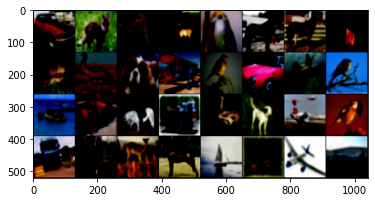

In [3]:
def showimage(image):
    image = image.numpy()
    image = image.transpose((1, 2, 0))
    plt.imshow(image)

images, labels = next(iter(trainloader))
showimage(torchvision.utils.make_grid(images))

In [4]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16 * 16 * 64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MyModel()
model

MyModel(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
)

In [11]:
train.train(model, 
      optim.SGD(params=model.parameters(), lr=0.001),
      trainloader, 
      testloader, epochs=3)

cuda
Epoch 0, Training loss: 4.467898277536733
Epoch 0, Validation loss: 4.158886432647705
Epoch 1, Training loss: 4.186899961783638
Epoch 1, Validation loss: 3.937715768814087
Epoch 2, Training loss: 3.9646972319023916
Epoch 2, Validation loss: 3.739825487136841
The final total accuracy is: 99.98800383877159


In [7]:
# load model
state_dict = torch.load("ninetynine.model")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [14]:
# save model
state_dict = model.state_dict()
torch.save(model, "ninetynine1.model")